In [ ]:
from pathlib import Path
import torch
from gelos.gelosdatamodule import GELOSDataModule
import yaml
from gelos import config
from lightning.pytorch import Trainer
from pathlib import Path
from tqdm import tqdm
from gelos.config import PROJ_ROOT, EXTERNAL_DATA_DIR, PROCESSED_DATA_DIR, DATA_VERSION, RAW_DATA_DIR
from terratorch.tasks import EmbeddingGenerationTask
from gelos.embedding_generation import LenientEmbeddingGenerationTask

2025-12-08 23:17:23.639 | INFO     | gelos.config:<module>:16 - PROJ_ROOT path is: /app
/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [ ]:
from lightning.pytorch.cli import instantiate_class

In [ ]:
yaml_file = "prithvieov2300_blueperturb.yaml"

In [ ]:
yaml_config_directory = PROJ_ROOT / 'gelos' / 'configs'
yaml_path = yaml_config_directory / yaml_file
print(yaml_path)

/app/gelos/configs/prithvieov2300_blueperturb.yaml


## Run Embedding Generation step by step

In [ ]:
with open(yaml_path, "r") as f:
        yaml_config = yaml.safe_load(f)

print(yaml.dump(yaml_config))

model_name = yaml_config['model']['init_args']['model']
output_dir = PROCESSED_DATA_DIR / DATA_VERSION / model_name
output_dir.mkdir(exist_ok=True, parents=True)
data_root = RAW_DATA_DIR / DATA_VERSION

# add variables to yaml config so it can be passed to classes
yaml_config['data']['init_args']['data_root'] = data_root
yaml_config['model']['init_args']['output_dir'] = output_dir

# instantiate transform classes if they exist
if "transform" in yaml_config["data"]["init_args"].keys():
      yaml_config["data"]["init_args"]["transform"] = [
            instantiate_class(args = (), init=class_path) for class_path in yaml_config["data"]["init_args"]["transform"]
      ]
gelos_datamodule = GELOSDataModule(**yaml_config['data']['init_args'])
task = LenientEmbeddingGenerationTask(**yaml_config['model']['init_args'])

device = 'gpu' if torch.cuda.is_available() else 'cpu'
trainer = Trainer(accelerator=device, devices=1)

data:
  class_path: gelos.gelosdatamodule.GELOSDataModule
  init_args:
    bands:
      S2L2A:
      - BLUE
      - GREEN
      - RED
      - NIR_NARROW
      - SWIR_1
      - SWIR_2
    batch_size: 1
    num_workers: 0
    perturb_bands:
      S2L2A:
      - BLUE
    transform:
    - class_path: terratorch.datasets.transforms.FlattenTemporalIntoChannels
    - class_path: albumentations.pytorch.transforms.ToTensorV2
    - class_path: terratorch.datasets.transforms.UnflattenTemporalFromChannels
      init_args:
        n_timesteps: 4
embedding_extraction_strategies:
  All Patches from April to June:
  - start: 37
    step: 1
    stop: 73
  All Steps of Middle Patch:
  - start: 19
    step: 36
    stop: null
  CLS Token:
  - start: 0
    step: 1
    stop: 1
model:
  class_path: terratorch.tasks.EmbeddingGenerationTask
  init_args:
    embed_file_key: filename
    embedding_pooling: null
    has_cls: true
    layers:
    - -1
    model: prithvi_eo_v2_300
    model_args:
      bands:
     

/opt/venv/lib/python3.11/site-packages/terratorch/tasks/embedding_generation.py:67: UserWarning: GeoTIFF selected; 2D token embeddings (ViT) will be reshaped to [C, sqrt(num_tokens), sqrt(num_tokens)] after dropping CLS if present.
  warnings.warn(
INFO:httpx:HTTP Request: HEAD https://huggingface.co/ibm-nasa-geospatial/Prithvi-EO-2.0-300M/resolve/main/Prithvi_EO_V2_300M.pt "HTTP/1.1 302 Found"
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed
/opt/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO: Using defau

### Inspect model and ensure weights have been loaded correctly

In [31]:
from models.prithvi_eo_v2 import PrithviViT

In [32]:
model_version = "300M"
prithvi_model = PrithviViT(num_frames = 4, in_chans = 6, model_size = model_version)
weights_path = EXTERNAL_DATA_DIR / "model_weights"/ f"Prithvi_EO_V2_{model_version}.pt"
state_dict = torch.load(weights_path)
encoder_state_dict = {}
for k, v in state_dict.items():
    if 'pos_embed' in k:
        continue
    if k.startswith('encoder'):
        new_key = k.replace("encoder.", "", 1)
        encoder_state_dict[new_key] = v

In [34]:
for k, v in task.model.named_parameters():
    weights = encoder_state_dict[k]
    print(k)
    print("mean weights from huggingface: ", weights.mean().item())
    print("mean weights from terratorch: ", v.mean().item())
    print("any equivalent: ", (weights == v).any().item())
    

cls_token
mean weights from huggingface:  0.000820714223664254
mean weights from terratorch:  0.000820714223664254
any equivalent:  True
patch_embed.proj.weight
mean weights from huggingface:  -0.00044657185208052397
mean weights from terratorch:  -0.00044657185208052397
any equivalent:  True
patch_embed.proj.bias
mean weights from huggingface:  -0.014625811949372292
mean weights from terratorch:  -0.014625811949372292
any equivalent:  True
blocks.0.norm1.weight
mean weights from huggingface:  0.397368848323822
mean weights from terratorch:  0.397368848323822
any equivalent:  True
blocks.0.norm1.bias
mean weights from huggingface:  -0.008639749139547348
mean weights from terratorch:  -0.008639749139547348
any equivalent:  True
blocks.0.attn.qkv.weight
mean weights from huggingface:  -1.5966246792231686e-05
mean weights from terratorch:  -1.5966246792231686e-05
any equivalent:  True
blocks.0.attn.qkv.bias
mean weights from huggingface:  -0.0024480826687067747
mean weights from terratorc

### Inspect outputs of dataset

In [ ]:
gelos_datamodule.setup(stage="predict")

In [ ]:
gelos_datamodule.dataset.means

{'S2L2A': [2046.738525390625,
  2346.2802734375,
  2593.03857421875,
  3703.0908203125,
  3543.164794921875,
  3048.239990234375]}

In [ ]:
%debug
for k, v in gelos_datamodule.dataset[1].items():
    if k == "image" and isinstance(v, dict):
        for sensor, data in v.items():
            print(sensor, data.shape)
    elif k == "image":
        print (k, v.shape)
    else:
        print(k, v)

> /app/gelos/gelosdataset.py(214)_perturb_band()
    212 
    213     def _perturb_band(self, output, sensor, band_index):
--> 214         loc = self.means[sensor][band_index]
    215         scale = self.stds[sensor][band_index]
    216         size = output[sensor][:, :, :, band_index].shape

{'S2L2A': [2046.738525390625, 2346.2802734375, 2593.03857421875, 3703.0908203125, 3543.164794921875, 3048.239990234375]}
{'S2L2A': [2046.738525390625, 2346.2802734375, 2593.03857421875, 3703.0908203125, 3543.164794921875, 3048.239990234375]}
{'S2L2A': [2046.738525390625, 2346.2802734375, 2593.03857421875, 3703.0908203125, 3543.164794921875, 3048.239990234375]}


TypeError: list indices must be integers or slices, not list

In [ ]:
sample = gelos_datamodule.dataset[1]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
self = gelos_datamodule.dataset

In [ ]:
vis_bands = self.rgb_bands

In [ ]:
vis_bands

{'S1RTC': [],
 'S2L2A': ['RED', 'GREEN', 'BLUE'],
 'landsat': ['red', 'green', 'blue'],
 'DEM': []}

In [ ]:
from gelos.gelosdataset import scale

In [ ]:
sample["image"]["S2L2A"][0].shape

torch.Size([4, 96, 96])

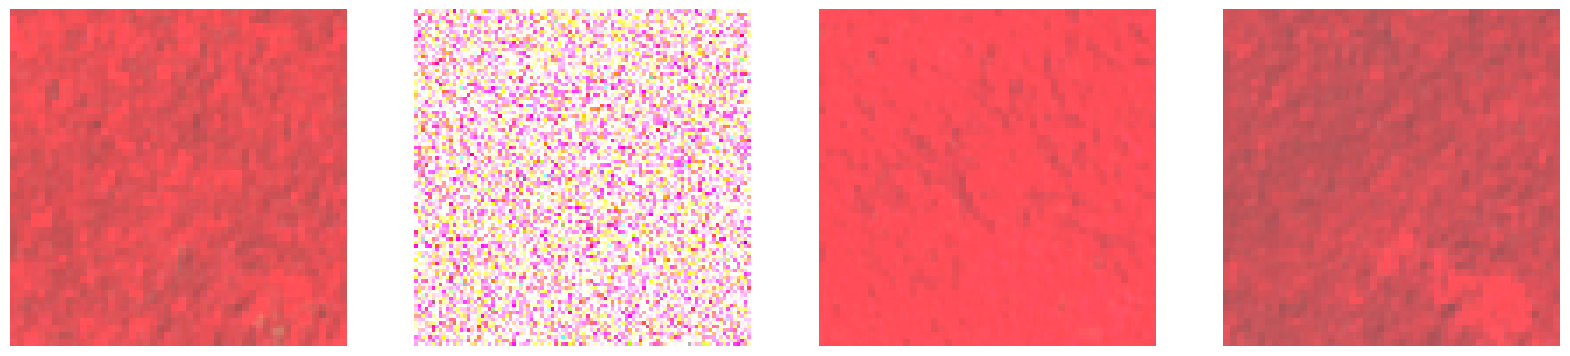

In [ ]:
nrows = 1
ncols = 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5), squeeze=False)
sens = list(self.bands.keys())[0]
if not isinstance(sample["image"], dict):
    sample["image"] = {sens: sample["image"]}

for row, sens in enumerate(self.bands.keys()):
    band_indices = [self.all_band_names[sens].index(band) for band in vis_bands[sens]]
    img = sample["image"][sens].numpy()
    img = scale(img)
    c, t, h, w = img.shape
    for col, t in enumerate(range(t)):
        img_t = img[band_indices,t,:,:].transpose(1,2,0)
        axs[row, col].imshow(img_t)
        axs[row, col].axis("off")

In [38]:
band_indices

[3, 2, 1]

In [44]:
print(img[:,1,:,:].mean())
print(img[:,2,:,:].mean())
print(img[:,3,:,:].mean())
print(img[0,:,:,:].mean())
print(img[1,:,:,:].mean())
print(img[2,:,:,:].mean())
print(img[3,:,:,:].mean())
print(img[4,:,:,:].mean())
print(img[5,:,:,:].mean())

0.88024026
0.4925217
0.46366897
0.44137222
0.474014
0.443596
0.920431
0.668922
0.5175178
